# Import Libraries

In [101]:
# data manipulation
import pandas as pd

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# NLP
import spacy
from spacy.tokens.doc import Doc
from wordcloud import WordCloud
import nltk
from nltk.probability import FreqDist
import re

# machine learning
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

nlp = spacy.load('en_core_web_md')

# Helper Functions

In [2]:
def get_n_color_palette(palette_name, n_colors, as_hex=False):
    palette = sns.color_palette(palette=palette_name, n_colors=n_colors)
    if as_hex:
        palette = palette.as_hex()
    palette.reverse()
    return palette

# Load and Prepare Data

In [3]:
newsgroups_data = fetch_20newsgroups(subset='all')

In [4]:
categories = newsgroups_data.target_names

In [5]:
df = pd.DataFrame(data={
    'text': newsgroups_data.data,
    'category': newsgroups_data.target
})

In [6]:
df['category'] = df['category'].apply(lambda x: categories[x])

In [7]:
df.head()

,text,category
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware


# What is this Data?

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups.

The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. `comp.sys.ibm.pc.hardware` / `comp.sys.mac.hardware`), while others are highly unrelated (e.g `misc.forsale` / `soc.religion.christian`).

Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:

<table style='font-family:"Courier New", Courier, monospace; font-size:80%'>
    <tr>
        <td>comp.graphics<br>comp.os.ms-windows.misc<br>comp.sys.ibm.pc.hardware<br>comp.sys.mac.hardware<br>comp.windows.x
        </td>
        <td>rec.autos<br>rec.motorcycles<br>rec.sport.baseball<br>rec.sport.hockey</td>
        <td>sci.crypt<br>sci.electronics<br>sci.med<br>sci.space</td>
    </tr>
    <tr>
        <td>misc.forsale</td>
        <td>talk.politics.misc<br>talk.politics.guns<br>talk.politics.mideast</td>
        <td>talk.religion.misc<br>alt.atheism<br>soc.religion.christian</td>
    </tr>
</table>

# Data Statistics

In [8]:
categories_statistics_df = df.groupby(by='category')['text'].agg({
                                'count': lambda x: x.size,
                                'mean': lambda x: x.str.len().mean(),
                                'max': lambda x: x.str.len().max(),
                                'min': lambda x: x.str.len().min()
                            })\
                            .reset_index()\
                            .sort_values(by='count', ascending=False)

/home/resaln/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



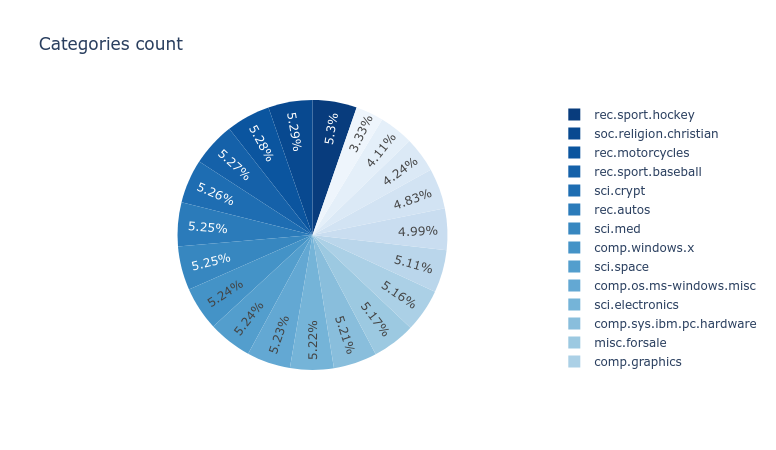

In [9]:
fig = px.pie(data_frame=categories_statistics_df, names='category', values='count',
            color_discrete_sequence=get_n_color_palette('Blues', 20, True),
            title='Categories count')
fig.show()

It's obvious that the dataset is *balanced*

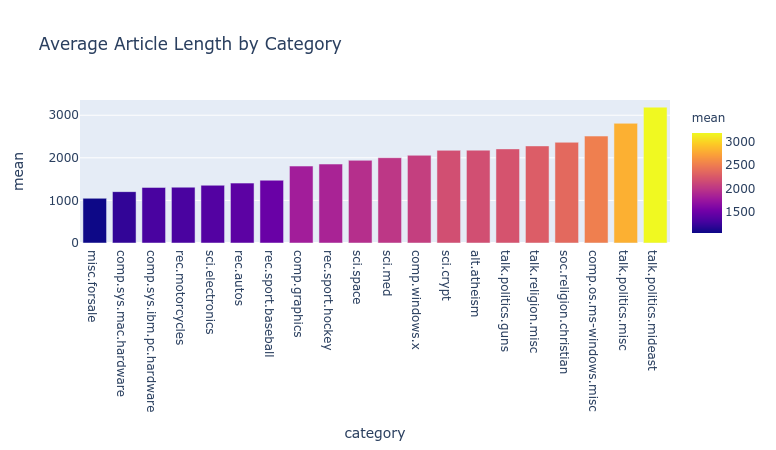

In [10]:
fig = px.bar(data_frame=categories_statistics_df.sort_values(by='mean'), x='category', y='mean',
            color='mean', title='Average Article Length by Category')
fig.show()

This chart shows how long the *polictics* articles, compared to *computer* articles

# Word Cloud

In [11]:
en_stop_words = nlp.Defaults.stop_words

In [12]:
categories_text_df = df.groupby(by='category')\
                        .agg({
                            'text': ' '.join
                        })\
                        .reset_index()

In [13]:
categories_text_df

,category,text
0,alt.atheism,From: kmr4@po.CWRU.edu (Keith M. Ryan)\nSubjec...
1,comp.graphics,From: ruocco@ghost.dsi.unimi.it (sergio ruocco...
2,comp.os.ms-windows.misc,From: gibsonm@cs.arizona.edu (Matthew H Gibson...
3,comp.sys.ibm.pc.hardware,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
4,comp.sys.mac.hardware,From: Alexander Samuel McDiarmid <am2o+@andrew...
5,comp.windows.x,From: cws@Faultline.Com (Carl Schmidtmann)\nSu...
6,misc.forsale,From: jtobias@cs.tamu.edu (Jason T Tobias)\nSu...
7,rec.autos,From: jackw@boi.hp.com (jack wood)\nSubject: R...
8,rec.motorcycles,From: mjs@sys.uea.ac.uk (Mike Sixsmith)\nSubje...
9,rec.sport.baseball,"Organization: Washington University, St. Louis..."


In [14]:
def plot_word_cloud(category_name, category_text):
    plt.subplots(figsize = (8,8))
    wc = WordCloud(background_color="white", stopwords=en_stop_words, width=1000, height=600)
    wc.generate(category_text)
    plt.title(label=category_name)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

In [15]:
# for idx, row in categories_text_df.iterrows():
#     category_name, category_text = row['category'], row['text']
#     plot_word_cloud(category_name, category_text)

## Bigrams WordCloud

In [16]:
text = categories_text_df[categories_text_df['category'] == 'talk.politics.mideast']\
                        ['text']\
                        .values[0]

In [17]:
bigrams = list(nltk.bigrams(text.split()))

In [18]:
bigrams_freq = dict(FreqDist(bigrams))

In [19]:
bigrams_freq = {
    ' '.join(k): v for k, v in bigrams_freq.items()
}

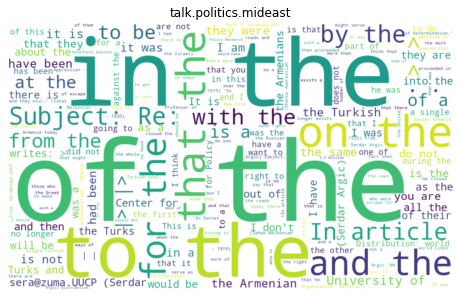

In [22]:
plt.subplots(figsize = (8,8))
wc = WordCloud(background_color="white", stopwords=en_stop_words, width=1000, height=600)
wc.generate_from_frequencies(bigrams_freq)
plt.title(label='talk.politics.mideast')
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

# Playing around with `spaCy`

In [23]:
category_name = 'talk.politics.mideast'

In [24]:
articles = df[df['category'] == category_name]['text'].to_list()

In [99]:
def is_clean_token(token):
    return not (token.like_num or token.is_digit or token.like_url 
                or token.like_email or token.is_stop or token.is_punct
                or not token.is_ascii or not token.is_alpha)

In [105]:
def clean_tokens_component(doc):
    clean_tokens = [token.text for token in doc if is_clean_token(token)]
    return Doc(doc.vocab, words=clean_tokens)

In [109]:
nlp.add_pipe(clean_tokens_component, last=True)